# Dependencies

In [2]:
! pip install git+https://github.com/openai/whisper.git
! pip install jiwer
! pip install pytorch-lightning
! pip install evaluate
! pip install mutagen
! pip install transformers

  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-w2qjg2sh
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-w2qjg2sh
  Resolved https://github.com/openai/whisper.git to commit c0d2f624c09dc18e709e37c2ad90c039a4eb72a2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
import os, numpy as np, pathlib
import torch, torch.nn
import pandas as pd
import whisper
import torchaudio, torchaudio.transforms
from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt, seaborn as sns
import evaluate
from transformers.optimization import get_linear_schedule_with_warmup
import jiwer
from whisper.normalizers import EnglishTextNormalizer
import warnings
warnings.filterwarnings('ignore')
import mutagen
from transformers import get_linear_schedule_with_warmup, AutoProcessor, AutoModelForSpeechSeq2Seq
from torch.optim import AdamW
from pathlib import Path
import openpyxl

#### Configuration

In [4]:
DATASET_DIR = "audio_dataset"
SAMPLE_RATE = 16000
AUDIO_MAX_LENGTH = 96000  # Maksimal panjang audio (6 detik * 16000)
TEXT_MAX_LENGTH = 200  # Maksimal panjang text transcript

TRAIN_RATE = 0.8  # 80% untuk training
VAL_RATE = 0.1    # 10% untuk validation
TEST_RATE = 0.1   # 10% untuk testing

TRAIN_BATCH_SIZE = 64  # Batch size untuk training
EVAL_BATCH_SIZE = 16    # Batch size untuk evaluation
MAX_TRAIN_STEPS = 150

SEED = 3407
seed_everything(SEED, workers=True)
DEVICE = "gpu" if torch.cuda.is_available() else "cpu"

class Config:

    sample_rate = 16000

    learning_rate = 1e-5
    weight_decay = 0.01
    adam_epsilon = 1e-8

    warmup_steps = 10  # 10 steps warmup dari 150 total steps
    max_steps = 150           # Minimum 150 Steps Training
    eval_steps = 25           # Evaluate setiap 25 steps
    save_steps = 50           # Save checkpoint setiap 50 steps
    train_batch_size = 8      # Batch size training
    eval_batch_size = 4       # Batch size evaluation
    num_worker = 2            # Number of workers untuk data loading
    gradient_accumulation_steps = 2  # Accumulate gradients untuk simulate larger batch

INFO:lightning_fabric.utilities.seed:Seed set to 3407


#### Utility Functions

In [5]:
def load_wave(wave_path, sample_rate: int = 16000):
    waveform = whisper.load_audio(wave_path, sr=sample_rate)
    return torch.from_numpy(waveform)


def calculate_err(data):
    normalizer = EnglishTextNormalizer()

    data['text_clean'] = data['text'].apply(normalizer)
    data['predict_clean'] = data['predict'].apply(normalizer)

    wer_original = jiwer.wer(list(data['text']), list(data['predict']))
    cer_original = jiwer.cer(list(data['text']), list(data['predict']))

    wer_normalized = jiwer.wer(list(data['text_clean']), list(data['predict_clean']))
    cer_normalized = jiwer.cer(list(data['text_clean']), list(data['predict_clean']))

    return (data, wer_original, wer_normalized, cer_original, cer_normalized)


def extract_aud(audio_path, mymodel):
    result = mymodel.transcribe(audio_path, language="id", without_timestamps=True)
    return result["text"]

#### Dataset Loading

In [6]:
TRANSCRIPTION_DIR = "transcription.csv"

def load_custom_dataset():
    audio_transcript_pair_list = []

    workbook = openpyxl.load_workbook(XLSX_DIR)
    sheet = workbook.active

    for row in sheet.iter_rows():
        row_values = []

        utterance_id, text, split = row[0].value, row[1].value, row[2].value
        audio_path = os.path.join(dataset_dir, f"{utterance_id}.wav")

        if os.path.exists(audio_path):
            print(f"{audio_path}")
            audio = mutagen.File(audio_path)
            audio_length = audio.info.length * 16000
            if len(text) <= TEXT_MAX_LENGTH and audio_length <= AUDIO_MAX_LENGTH:
                audio_transcript_pair_list.append((utterance_id, audio_path, text))
        else:
            print(f"WARNING: AUDIO FILE NOT FOUND {audio_path}")

    return audio_transcript_pair_list


def split_dataset(audio_transcript_pair_list, train_rate=0.8, val_rate=0.1, test_rate=0.1):
    """
    TODO: Split dataset menjadi train, validation, dan test sets

    Args:
        audio_transcript_pair_list: List of audio-text pairs
        train_rate: Proporsi untuk training set
        val_rate: Proporsi untuk validation set
        test_rate: Proporsi untuk test set

    Returns:
        tuple: (train_list, val_list, test_list)

    TODO IMPLEMENTASI:
    1. Shuffle dataset dengan random seed untuk reproducibility
    2. Calculate split indices berdasarkan proportions
    3. Split data menjadi 3 bagian: train, validation, test
    4. Pastikan total proportions = 1.0
    5. Return 3 separate lists
    """
    # TODO: Implement dataset splitting logic

    np.random.seed(SEED)
    np.random.shuffle(audio_transcript_pair_list)

    total_rate = train_rate + val_rate + test_rate
    if abs(total_rate - 1.0) > 1e-9:
        print(f"Warning: Dataset split rates ({total_rate}) do not sum to 1.0. Adjusting.")
        train_rate /= total_rate
        val_rate /= total_rate
        test_rate /= total_rate

    dataset_size = len(audio_transcript_pair_list)

    train_size = int(train_rate * dataset_size)
    val_size = int(val_rate * dataset_size)
    test_size = dataset_size - train_size - val_size

    print(f"Train size: {train_size}, Val size: {val_size}, Test size: {test_size}")

    train_list = audio_transcript_pair_list[:train_size]
    val_list = audio_transcript_pair_list[train_size:train_size + val_size]
    test_list = audio_transcript_pair_list[train_size + val_size:]

    return train_list, val_list, test_list

#### Dataset Class

In [7]:
# TODO: Implementasikan Dataset class dan Data Collator untuk PyTorch DataLoader

class CustomSpeechDataset(torch.utils.data.Dataset):
    """
    TODO: Custom Dataset class untuk Javanese Speech Recognition

    TODO IMPLEMENTASI:
    1. Inherit dari torch.utils.data.Dataset
    2. Implement __len__ untuk return jumlah samples
    3. Implement __getitem__ untuk return single sample
    4. Process audio menjadi mel spectrogram (format input Whisper)
    5. Tokenize text menggunakan Whisper tokenizer
    6. Return dictionary dengan keys: input_ids, labels, dec_input_ids
    """

    def __init__(self, audio_info_list, tokenizer, sample_rate):
        """
        TODO: Initialize dataset dengan audio info list dan tokenizer
        """
        # TODO: Store audio_info_list, tokenizer, sample_rate
        super().__init__()

        self.audio_info_list = audio_info_list
        self.tokenizer = tokenizer
        self.sample_rate = sample_rate

    def __len__(self):
        """TODO: Return total number of samples"""
        # TODO: Return length of audio_info_list
        return len(self.audio_info_list)

    def __getitem__(self, id):
        """
        TODO: Get single sample dari dataset

        TODO IMPLEMENTASI:
        1. Load audio dari path
        2. Convert audio ke mel spectrogram menggunakan Whisper preprocessing
        3. Tokenize text dengan special tokens (SOT, EOT)
        4. Prepare decoder input dan labels untuk training
        5. Return dictionary dengan semua components
        """
        # TODO: Implement getitem logic
        _, audio_path, text = self.audio_info_list[id]

        waveform = load_wave(audio_path, sample_rate=self.sample_rate)
        waveform = whisper.pad_or_trim(waveform.flatten())
        mel = whisper.log_mel_spectrogram(waveform)

        text_tokens = self.tokenizer.encode(text)
        text = [*self.tokenizer.sot_sequence_including_notimestamps] + self.tokenizer.encode(text)
        labels = text[1:] + [self.tokenizer.eot]

        return {
            "input_ids": mel,
            "labels": labels,
            "dec_input_ids": text
        }

class WhisperDataCollatorWithPadding:
    """
    TODO: Data collator untuk batch processing dengan dynamic padding

    TODO IMPLEMENTASI:
    1. Collect semua input_ids, labels, dan dec_input_ids dari batch
    2. Pad sequences ke length yang sama dalam batch
    3. Convert ke torch tensors
    4. Handle variable length sequences dengan padding
    5. Use -100 untuk ignored tokens dalam labels (standard PyTorch convention)
    """

    def __call__(self, features):
        """
        TODO: Process batch of features dan apply padding

        Args:
            features: List of dictionaries dari __getitem__

        Returns:
            dict: Batched dan padded tensors
        """
        # TODO: Implement batch collation dan padding logic

        input_ids, labels, dec_input_ids = [], [], []
        for f in features:
            input_ids.append(f["input_ids"])
            labels.append(f["labels"])
            dec_input_ids.append(f["dec_input_ids"])

        input_ids = torch.concat([input_id[None, :] for input_id in input_ids])

        label_lengths = [len(lab) for lab in labels]
        dec_input_ids_length = [len(e) for e in dec_input_ids]
        max_label_len = max(label_lengths+dec_input_ids_length)

        labels = [np.pad(lab, (0, max_label_len - lab_len), 'constant', constant_values=-100) for lab, lab_len in zip(labels, label_lengths)]
        dec_input_ids = [np.pad(e, (0, max_label_len - e_len), 'constant', constant_values=50257) for e, e_len in zip(dec_input_ids, dec_input_ids_length)] # 50257 is eot token id

        batch = {
            "labels": labels,
            "dec_input_ids": dec_input_ids
        }

        batch = {k: torch.tensor(np.array(v), requires_grad=False) for k, v in batch.items()}
        batch["input_ids"] = input_ids

        return batch

#### Whisper Finetuning Class

In [8]:
# TODO: Implementasikan Whisper Fine-tuning Module menggunakan PyTorch Lightning

class WhisperModelModule(LightningModule):
    """
    TODO: PyTorch Lightning Module untuk fine-tuning Whisper model (STEP-BASED TRAINING)

    TODO IMPLEMENTASI:
    1. Inherit dari LightningModule untuk automatic training loop
    2. Load pretrained Whisper model
    3. Fine-tune both encoder and decoder
    4. Implement training_step dan validation_step
    5. Setup optimizer dan scheduler
    6. Setup data loaders
    """

    def __init__(self, cfg, model_name="tiny", lang="id", train_dataset=[], eval_dataset=[]):
        """
        TODO: Initialize Whisper model untuk fine-tuning

        TODO IMPLEMENTASI:
        1. Setup Whisper decoding options dengan Indonesian language
        2. Load pretrained Whisper model
        3. Setup loss function dan metrics
        4. Store configuration dan datasets
        """
        # TODO: Implement initialization logic

        super().__init__()
        self.options = whisper.DecodingOptions(language="id", without_timestamps=True, task="transcribe")
        self.tokenizer = whisper.tokenizer.get_tokenizer(True, language="id", task=self.options.task)

        self.model = whisper.load_model(model_name)

        self.loss_fn = torch.nn.CrossEntropyLoss(ignore_index=-100)
        self.metrics_wer = evaluate.load("wer")
        self.metrics_cer = evaluate.load("cer")

        self.cfg = cfg
        self.train_dataset = train_dataset
        self.eval_dataset = eval_dataset

    def forward(self, x):
        """TODO: Forward pass melalui model"""
        # TODO: Implement forward pass
        return self.model(x)

    def training_step(self, batch, batch_id):
        """
        TODO: Single training step untuk STEP-BASED training

        TODO IMPLEMENTASI:
        1. Extract mel spectrogram, labels, dan decoder inputs dari batch
        2. Forward pass melalui encoder
        3. Forward pass melalui decoder
        4. Calculate loss menggunakan CrossEntropyLoss
        5. Log training loss dengan step number
        6. Monitor step count
        """
        # TODO: Implement training step logic
        input_ids = batch["input_ids"]
        labels = batch["labels"].long()
        dec_input_ids = batch["dec_input_ids"].long()

        with torch.no_grad():
            audio_features = self.model.encoder(input_ids)

        out = self.model.decoder(dec_input_ids, audio_features)

        loss = self.loss_fn(out.view(-1, out.size(-1)), labels.view(-1))

        self.log("train/loss", loss, on_step=True, prog_bar=True, logger=True)

        return loss

    def validation_step(self, batch, batch_id):
        """
        TODO: Single validation step dengan metrics calculation

        TODO IMPLEMENTASI:
        1. Similar dengan training_step tapi tanpa gradient
        2. Calculate loss untuk monitoring
        3. Decode predictions untuk WER/CER calculation
        4. Log validation metrics setiap eval_steps
        """
        # TODO: Implement validation step logic
        input_ids = batch["input_ids"]
        labels = batch["labels"].long()
        dec_input_ids = batch["dec_input_ids"].long()
        audio_features = self.model.encoder(input_ids)
        out = self.model.decoder(dec_input_ids, audio_features)

        loss = self.loss_fn(out.view(-1, out.size(-1)), labels.view(-1))

        # Correcting the decoding part
        # Use argmax to get predicted token ids
        predicted_ids = torch.argmax(out, dim=2)

        # Decode predicted and reference token ids
        o_list, l_list = [], []
        for pred, ref in zip(predicted_ids, labels):
            # Decode predicted tokens, excluding padding
            # The tokenizer.decode method from whisper does not accept skip_special_tokens
            # Filter out the padding token (-100) and EOT token if present in predictions
            o_list.append(self.tokenizer.decode([token.item() for token in pred if token.item() != -100 and token.item() != tokenizer.eot]))
            # Decode reference tokens, excluding padding
            l_list.append(self.tokenizer.decode([token.item() for token in ref if token.item() != -100]))

        cer = self.metrics_cer.compute(references=l_list, predictions=o_list)
        wer = self.metrics_wer.compute(references=l_list, predictions=o_list)


        self.log("val/loss", loss, on_step=True, prog_bar=True, logger=True)
        self.log("val/cer", cer, on_step=True, prog_bar=True, logger=True)
        self.log("val/wer", wer, on_step=True, prog_bar=True, logger=True)

        return {
            "cer": cer,
            "wer": wer,
            "loss": loss
        }


    def configure_optimizers(self):
        """
        TODO: Setup optimizer dan learning rate scheduler untuk STEP-BASED training

        TODO IMPLEMENTASI:
        1. Setup AdamW optimizer dengan weight decay
        2. Include both encoder dan decoder parameters dalam optimization
        3. Setup linear warmup scheduler
        4. Warmup = 10 steps, total = 150 steps
        5. Return optimizer dan scheduler configuration
        """
        # TODO: Implement optimizer configuration

        model = self.model
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in model.named_parameters()
                            if not any(nd in n for nd in no_decay)],
                "weight_decay": self.cfg.weight_decay,
            },
            {
                "params": [p for n, p in model.named_parameters()
                            if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        optimizer = AdamW(optimizer_grouped_parameters,
                          lr=self.cfg.learning_rate,
                          eps=self.cfg.adam_epsilon)

        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=self.cfg.warmup_steps,
            num_training_steps=self.cfg.max_steps
        )

        return [optimizer], [{"scheduler": scheduler, "interval": "step", "frequency": 1}]

    def train_dataloader(self):
        """TODO: Setup training data loader"""
        # TODO: Implement train dataloader

        dataset = CustomSpeechDataset(self.train_dataset, self.tokenizer, self.cfg.sample_rate)
        return torch.utils.data.DataLoader(dataset,
                          batch_size=self.cfg.train_batch_size,
                          drop_last=True, shuffle=True, num_workers=self.cfg.num_worker,
                          collate_fn=WhisperDataCollatorWithPadding()
                          )

    def val_dataloader(self):
        """TODO: Setup validation data loader"""
        # TODO: Implement validation dataloader
        dataset = CustomSpeechDataset(self.eval_dataset, self.tokenizer, self.cfg.sample_rate)
        return torch.utils.data.DataLoader(dataset,
                          batch_size=self.cfg.eval_batch_size,
                          num_workers=self.cfg.num_worker,
                          collate_fn=WhisperDataCollatorWithPadding()
                          )

#### Whisper From Scratch

In [9]:
# TODO: Implementasikan Whisper From Scratch Training Class

class WhisperFromScratch:
    """
    TODO: Class untuk training Whisper model dari scratch

    TODO IMPLEMENTASI:
    1. Load Whisper architecture tapi reset semua weights ke random values
    2. Implement custom training loop
    3. Implement loss calculation
    4. Implement evaluation methods
    5. Save/load model checkpoints
    """

    def __init__(self, model_name='tiny'):
        """
        TODO: Initialize Whisper architecture dengan random weights

        TODO IMPLEMENTASI:
        1. Load Whisper architecture
        2. Reset semua parameters ke random values
        3. Setup tokenizer
        4. Store model dimensions
        """
        # TODO: Implement initialization logic
        self.model = whisper.load_model(model_name)
        self._reset_parameters()
        self.options = whisper.DecodingOptions(language="id", without_timestamps=True, task="transcribe")
        self.tokenizer = whisper.tokenizer.get_tokenizer(True, language="id", task=self.options.task)

    def _reset_parameters(self):
        """
        TODO: Reset semua parameters ke random values untuk training from scratch

        TODO IMPLEMENTASI:
        1. Iterate semua modules dalam model
        2. Reset Linear dan Convolution layers dengan Xavier initialization
        3. Reset LayerNorm parameters
        4. Pastikan semua weights tidak menggunakan pretrained values
        """
        # TODO: Implement parameter reset logic
        for m in self.model.modules():
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.Conv1d):
                 torch.nn.init.xavier_uniform_(m.weight)
                 if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.ConvTranspose1d):
                 torch.nn.init.xavier_uniform_(m.weight)
                 if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.LayerNorm):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)


    def forward(self, mel, tokens):
        """
        TODO: Forward pass melalui model

        TODO IMPLEMENTASI:
        1. Pass mel spectrogram melalui encoder
        2. Pass tokens dan audio features melalui decoder
        3. Return logits untuk probability distribution
        """
        # TODO: Implement forward pass
        audio_features = self.model.encoder(mel)
        logits = self.model.decoder(tokens, audio_features)
        return logits

    def compute_loss(self, mel, labels):
        """
        TODO: Compute training loss

        TODO IMPLEMENTASI:
        1. Forward pass with shifted tokens (decoder input)
        2. Calculate cross entropy loss between predictions and targets (labels)
        3. Handle token clamping for vocabulary bounds
        4. Return scalar loss
        """
        # TODO: Implement loss computation

        # Ensure labels are on the same device as the model
        labels = labels.to(self.model.device)

        # Create decoder input by shifting labels to the right
        dec_input_ids = labels.clone()
        # Shift tokens to the right, prepending with the SOT token and removing the last token
        # Assuming the first token in labels is SOT or equivalent
        # For simplicity, let's assume the data collator provides dec_input_ids correctly
        # If using labels directly, you'd typically do:
        # dec_input_ids = labels[:, :-1]
        # decoder_start_token_id = self.tokenizer.sot_sequence_including_notimestamps[0]
        # dec_input_ids = torch.cat([torch.full((labels.shape[0], 1), decoder_start_token_id, device=labels.device), labels[:, :-1]], dim=1)
        # Replace -100 padding in dec_input_ids with a valid token like EOT or a dedicated pad token
        # A common approach is to use the SOT token for padding the decoder input
        dec_input_ids[dec_input_ids == -100] = self.tokenizer.sot_sequence_including_notimestamps[0]


        # Ensure token IDs are within the valid range of the token embedding layer
        max_token_id = self.model.decoder.token_embedding.num_embeddings - 1
        dec_input_ids = torch.clamp(dec_input_ids, max=max_token_id)

        with torch.no_grad():
          audio_features = self.model.encoder(mel.to(self.model.device))

        # The decoder expects the shifted sequence as input
        logits = self.model.decoder(dec_input_ids, audio_features)

        # The loss is computed between the predicted logits and the original labels
        loss = torch.nn.functional.cross_entropy(logits.view(-1, logits.size(-1)), labels.view(-1), ignore_index=-100) # Use -100 for padding

        return loss

    def train_from_scratch(self, train_loader, val_loader, max_steps=150, learning_rate=1e-4, device='cuda'):
        """
        TODO: Training loop for from scratch training

        TODO IMPLEMENTASI:
        1. Setup optimizer and scheduler
        2. Implement step-based training loop
        3. Calculate training and validation losses every eval_steps
        4. Save best model based on validation loss
        5. Implement gradient clipping for stability
        6. Stop training after 150 steps are reached (default)
        7. Return training curves for analysis
        """
        # TODO: Implement step-based training loop
        optimizer = AdamW(self.model.parameters(), lr=learning_rate)
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=1, num_training_steps=max_steps
        )

        self.model.to(device)
        self.model.train()

        train_losses = []
        val_losses = []
        best_val_loss = float('inf')

        train_iter = iter(train_loader)

        for step in tqdm(range(max_steps)):
            try:
                batch = next(train_iter)
            except StopIteration:
                train_iter = iter(train_loader)
                batch = next(train_iter)

            mel = batch["input_ids"].to(device)
            labels = batch["labels"].to(device) # Labels are the targets

            loss = self.compute_loss(mel, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0) # Gradient clipping
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

            train_losses.append(loss.item())

            if (step + 1) % Config().eval_steps == 0: # Evaluate every 25 steps
                self.model.eval()
                val_loss = 0
                with torch.no_grad():
                    for val_batch in val_loader:
                        val_mel = val_batch["input_ids"].to(device)
                        val_labels = val_batch["labels"].to(device) # Labels are the targets
                        val_loss += self.compute_loss(val_mel, val_labels).item()
                val_loss /= len(val_loader)
                val_losses.append(val_loss)
                print(f"Step {step+1}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_loss:.4f}")

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    torch.save(self.model.state_dict(), "best_scratch_model_indonesia.pth")

                self.model.train()

        return train_losses, val_losses


    def transcribe(self, audio_path):
        """
        TODO: Transcribe audio using trained model

        TODO IMPLEMENTASI:
        1. Set model to eval mode
        2. Use base model transcribe method
        3. Return transcription result
        """
        # TODO: Implement transcription logic
        self.model.eval()
        with torch.no_grad():
            result = self.model.transcribe(audio_path, language="id", without_timestamps=True)
        return result["text"]

#### Split Dataset

In [10]:
# TODO: Implementasikan complete training pipeline

# Load dan split dataset
# TODO: Load Custom ASR dataset dari DATASET_DIR
# TODO: Split dataset menjadi train/val/test dengan proper ratios
# TODO: Print dataset statistics

# IMPLEMENTASI:
# 1. Call load_custom_dataset(DATASET_DIR)
# 2. Call split_dataset() dengan train/val/test ratios
# 3. Verify dataset sizes dan print summary

audio_transcript_pair_list = load_custom_dataset(DATASET_DIR)
audio_transcript_pair_list = audio_transcript_pair_list[:50]
train_list, val_list, test_list = split_dataset(audio_transcript_pair_list, 0.8, 0.1, 0.1)
total_samples = len(train_list) + len(val_list) + len(test_list)
print(f"Train samples: {len(train_list)}")
print(f"Val samples: {len(val_list)}")
print(f"Test samples: {len(test_list)}")
print(f"Is total samples match dataset: {total_samples == len(audio_transcript_pair_list)}")

/content/drive/MyDrive/SPOKEN/data_indonesia/TVRI_BS_071119_0001.wav
/content/drive/MyDrive/SPOKEN/data_indonesia/TVRI_BS_071119_0002.wav
/content/drive/MyDrive/SPOKEN/data_indonesia/TVRI_BS_071119_0003.wav
/content/drive/MyDrive/SPOKEN/data_indonesia/TVRI_BS_071119_0004.wav
/content/drive/MyDrive/SPOKEN/data_indonesia/TVRI_BS_071119_0005.wav
/content/drive/MyDrive/SPOKEN/data_indonesia/TVRI_BS_071119_0006.wav
/content/drive/MyDrive/SPOKEN/data_indonesia/TVRI_BS_071119_0007.wav
/content/drive/MyDrive/SPOKEN/data_indonesia/TVRI_BS_071119_0010.wav
/content/drive/MyDrive/SPOKEN/data_indonesia/TVRI_BS_071119_0013.wav
/content/drive/MyDrive/SPOKEN/data_indonesia/TVRI_BS_071119_0019.wav
/content/drive/MyDrive/SPOKEN/data_indonesia/TVRI_BS_071119_0020.wav
/content/drive/MyDrive/SPOKEN/data_indonesia/TVRI_BS_071119_0022.wav
/content/drive/MyDrive/SPOKEN/data_indonesia/TVRI_BS_071119_0025.wav
/content/drive/MyDrive/SPOKEN/data_indonesia/TVRI_BS_071119_0028.wav
/content/drive/MyDrive/SPOKEN/data

#### Training

In [11]:
log_output_dir = "/content/logs_indonesia"
check_output_dir = "/content/artifacts_indonesia"
train_name = "whisper"
model_name = "tiny"
lang = "id"

In [12]:
# TODO: Setup dan jalankan training untuk kedua approaches

# Setup configuration dan directories
# TODO: Initialize Config() dengan step-based parameters
# TODO: Create directories untuk logging dan checkpoints
# TODO: Set max_steps = 150, eval_steps = 25, save_steps = 50

cfg = Config()

Path(log_output_dir).mkdir(exist_ok=True)
Path(check_output_dir).mkdir(exist_ok=True)

tflogger = TensorBoardLogger(
    save_dir=log_output_dir,
    name=train_name,
)

checkpoint_callback = ModelCheckpoint(
    dirpath=f"{check_output_dir}/checkpoint",
    filename="checkpoint-{epoch:04d}",
    save_top_k=-1 # all model save
)

In [13]:
# Setup data loaders untuk from-scratch training
# TODO: Create tokenizer dengan Indonesian language
# TODO: Create CustomSpeechDataset untuk train dan validation
# TODO: Create DataLoaders with appropriate batch sizes
# TODO: Setup WhisperDataCollatorWithPadding

options = whisper.DecodingOptions(language="id", without_timestamps=True, task="transcribe")
tokenizer = whisper.tokenizer.get_tokenizer(True, language="id", task=options.task)

train_dataset_scratch = CustomSpeechDataset(train_list, tokenizer, SAMPLE_RATE)
val_dataset_scratch = CustomSpeechDataset(val_list, tokenizer, SAMPLE_RATE)

data_collator_scratch = WhisperDataCollatorWithPadding()

train_loader_scratch = torch.utils.data.DataLoader(
    train_dataset_scratch,
    batch_size=Config().train_batch_size,
    shuffle=True,
    collate_fn=data_collator_scratch
)

val_loader_scratch = torch.utils.data.DataLoader(
    val_dataset_scratch,
    batch_size=Config().eval_batch_size,
    shuffle=False,
    collate_fn=data_collator_scratch
)

# FROM SCRATCH TRAINING

"""
TODO IMPLEMENTASI FROM SCRATCH:
1. Create WhisperFromScratch model with random weights
2. Train model with max_steps=150 (default)
3. Evaluate every 25 steps (default)
4. Monitor training and validation losses per step
5. Save best model based on validation performance
6. Track training curves for analysis
"""

# TODO: Implement from scratch training

print("STARTING FROM-SCRATCH TRAINING...")

model_scratch = WhisperFromScratch('tiny')
train_losses_scratch, val_losses_scratch = model_scratch.train_from_scratch(
    train_loader_scratch,
    val_loader_scratch,
    max_steps=Config().max_steps,
    learning_rate=Config().learning_rate,
    device=DEVICE
)

print("FROM-SCRATCH TRAINING FINISHED.")

STARTING FROM-SCRATCH TRAINING...


  0%|          | 0/6 [00:00<?, ?it/s]

Step 6: Train Loss = 10.6717, Val Loss = 10.7098
FROM-SCRATCH TRAINING FINISHED.


In [14]:
checkpoint_path = "/content/artifacts/checkpoint/checkpoint-epoch=0005.ckpt"
state_dict = torch.load(checkpoint_path)
state_dict = state_dict['state_dict']

whisper_fine_tuned_model = WhisperModelModule(cfg)
whisper_fine_tuned_model.load_state_dict(state_dict)

<All keys matched successfully>

In [15]:
options = whisper.DecodingOptions(language="id", without_timestamps=True, task="transcribe")
tokenizer = whisper.tokenizer.get_tokenizer(True, language="id", task=options.task)
dataset = CustomSpeechDataset(val_list, tokenizer, SAMPLE_RATE)
loader = torch.utils.data.DataLoader(dataset, batch_size=2, collate_fn=WhisperDataCollatorWithPadding())

refs = []
res = []
for b in tqdm(loader):
    input_ids = b["input_ids"].half()
    labels = b["labels"].long()
    with torch.no_grad():
        results = whisper_fine_tuned_model.model.decode(input_ids, options)
        for r in results:
            res.append(r.text)

        for l in labels:
            filtered_l = [token.item() for token in l if token.item() != -100 and token.item() != tokenizer.eot]
            ref = tokenizer.decode(filtered_l)
            refs.append(ref)

  0%|          | 0/3 [00:00<?, ?it/s]

In [16]:
cer_metrics = evaluate.load("cer")
cer_metrics.compute(references=refs, predictions=res)

0.5011185682326622

In [17]:
model_path = 'best_scratch_model_indonesia.pth'
state_dict = torch.load(model_path)
whisper_from_scratch_model = WhisperFromScratch('tiny')
whisper_from_scratch_model.model.load_state_dict(state_dict)

<All keys matched successfully>

In [18]:
options = whisper.DecodingOptions(language="id", without_timestamps=True, task="transcribe")
tokenizer = whisper.tokenizer.get_tokenizer(True, language="id", task=options.task)
dataset = CustomSpeechDataset(val_list, tokenizer, SAMPLE_RATE)
loader = torch.utils.data.DataLoader(dataset, batch_size=2, collate_fn=WhisperDataCollatorWithPadding())

refs = []
res = []
for b in tqdm(loader):
    input_ids = b["input_ids"].half()
    labels = b["labels"].long()
    with torch.no_grad():
        results = whisper_from_scratch_model.model.decode(input_ids, options)
        for r in results:
            res.append(r.text)

        for l in labels:
            filtered_l = [token.item() for token in l if token.item() != -100 and token.item() != tokenizer.eot]
            ref = tokenizer.decode(filtered_l)
            refs.append(ref)

  0%|          | 0/3 [00:00<?, ?it/s]

In [19]:
cer_metrics = evaluate.load("cer")
cer_metrics.compute(references=refs, predictions=res)

5.096196868008948

#### Evaluation

In [20]:
# TODO: Implementasikan comprehensive evaluation untuk semua models
"""
EVALUATION STRATEGY:
1. Zero-shot: Pretrained Whisper tanpa fine-tuning
2. From Scratch: Model yang ditraining dari random weights
3. Fine-tuned: Model yang di-fine-tune dari pretrained weights

Metrics yang digunakan:
- WER (Word Error Rate): Error rate di level kata
- CER (Character Error Rate): Error rate di level karakter
"""

# TODO: Prepare test data
# TODO: Create DataFrame dari test_list dengan kolom ['utterance_id', 'audio_path', 'text']

test_df = pd.DataFrame(test_list, columns=['utterance_id', 'audio_path', 'text'])

# EVALUATION 1: ZERO-SHOT (BASELINE)

"""
TODO IMPLEMENTASI ZERO-SHOT EVALUATION:
1. Load pretrained Whisper model tanpa modification
2. Transcribe test audio menggunakan model original
3. Calculate WER dan CER menggunakan calculate_err()
"""

# TODO: Implement zero-shot evaluation
# TODO: Load model_zeroshot = whisper.load_model('tiny')
# TODO: Loop through test samples dan transcribe
# TODO: Calculate metrics dan store results

print("EVALUATING ZERO-SHOT MODEL...")
model_zeroshot = whisper.load_model('tiny')
model_zeroshot.eval()
model_zeroshot.to(DEVICE)

zero_shot_predictions = []
for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Transcribing Zero-Shot"):
    prediction = extract_aud(row['audio_path'], model_zeroshot)
    zero_shot_predictions.append(prediction)

test_df['predict_zero_shot'] = zero_shot_predictions
_, wer_zero_shot_orig, wer_zero_shot_norm, cer_zero_shot_orig, cer_zero_shot_norm = calculate_err(test_df.rename(columns={'predict_zero_shot': 'predict'}))

print(f"Zero-Shot WER (Original): {wer_zero_shot_orig:.4f}")
print(f"Zero-Shot WER (Normalized): {wer_zero_shot_norm:.4f}")
print(f"Zero-Shot CER (Original): {cer_zero_shot_orig:.4f}")
print(f"Zero-Shot CER (Normalized): {cer_zero_shot_norm:.4f}")

# EVALUATION 2: FROM SCRATCH MODEL (AFTER 150 STEPS)

"""
TODO IMPLEMENTASI FROM SCRATCH EVALUATION:
1. Load best model dari from-scratch training
2. Transcribe test audio menggunakan trained model
3. Calculate WER dan CER
"""

# TODO: Implement from scratch evaluation
# TODO: Use model_scratch yang sudah ditraining
# TODO: Loop through test samples dan transcribe
# TODO: Calculate metrics dan store results

print("\nEVALUATING FROM-SCRATCH MODEL...")
if whisper_from_scratch_model:
    whisper_from_scratch_model.model.to(DEVICE)
    scratch_predictions = []
    for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Transcribing From-Scratch"):
        prediction = whisper_from_scratch_model.transcribe(row['audio_path'])
        scratch_predictions.append(prediction)

    test_df['predict_scratch'] = scratch_predictions
    _, wer_scratch_orig, wer_scratch_norm, cer_scratch_orig, cer_scratch_norm = calculate_err(test_df.rename(columns={'predict_scratch': 'predict'}))

    print(f"From-Scratch WER (Original): {wer_scratch_orig:.4f}")
    print(f"From-Scratch WER (Normalized): {wer_scratch_norm:.4f}")
    print(f"From-Scratch CER (Original): {cer_scratch_orig:.4f}")
    print(f"From-Scratch CER (Normalized): {cer_scratch_norm:.4f}")
else:
    print("From-scratch model not found. Skipping evaluation.")


# EVALUATION 3: FINE-TUNED MODEL (AFTER 150 STEPS)

"""
TODO IMPLEMENTASI FINE-TUNED EVALUATION:
1. Load best checkpoint dari fine-tuning
2. Transcribe test audio menggunakan fine-tuned model
3. Calculate WER dan CER
"""

# TODO: Implement fine-tuned evaluation
# TODO: Use fine_tuned_model yang sudah ditraining
# TODO: Loop through test samples dan transcribe
# TODO: Calculate metrics dan store results

print("\nEVALUATING FINE-TUNED MODEL...")

fine_tuned_model = whisper_fine_tuned_model

if fine_tuned_model:
    fine_tuned_model.to(DEVICE)
    fine_tuned_predictions = []
    # Need to use the base whisper model object within the LightningModule
    for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Transcribing Fine-Tuned"):
        prediction = extract_aud(row['audio_path'], fine_tuned_model.model)
        fine_tuned_predictions.append(prediction)

    test_df['predict_fine_tuned'] = fine_tuned_predictions
    _, wer_fine_tuned_orig, wer_fine_tuned_norm, cer_fine_tuned_orig, cer_fine_tuned_norm = calculate_err(test_df.rename(columns={'predict_fine_tuned': 'predict'}))

    print(f"Fine-Tuned WER (Original): {wer_fine_tuned_orig:.4f}")
    print(f"Fine-Tuned WER (Normalized): {wer_fine_tuned_norm:.4f}")
    print(f"Fine-Tuned CER (Original): {cer_fine_tuned_orig:.4f}")
    print(f"Fine-Tuned CER (Normalized): {cer_fine_tuned_norm:.4f}") # Corrected typo in variable name
else:
    print("Fine-tuned model not found. Skipping evaluation.")

EVALUATING ZERO-SHOT MODEL...


Transcribing Zero-Shot:   0%|          | 0/5 [00:00<?, ?it/s]

Zero-Shot WER (Original): 0.7353
Zero-Shot WER (Normalized): 0.5588
Zero-Shot CER (Original): 0.1633
Zero-Shot CER (Normalized): 0.1364

EVALUATING FROM-SCRATCH MODEL...


Transcribing From-Scratch:   0%|          | 0/5 [00:00<?, ?it/s]

From-Scratch WER (Original): 17.7353
From-Scratch WER (Normalized): 17.9412
From-Scratch CER (Original): 18.6041
From-Scratch CER (Normalized): 18.8595

EVALUATING FINE-TUNED MODEL...


Transcribing Fine-Tuned:   0%|          | 0/5 [00:00<?, ?it/s]

Fine-Tuned WER (Original): 0.7059
Fine-Tuned WER (Normalized): 0.6176
Fine-Tuned CER (Original): 0.1755
Fine-Tuned CER (Normalized): 0.1446


In [21]:
test_df

,utterance_id,audio_path,text,predict_zero_shot,predict_scratch,predict_fine_tuned
0,TVRI_BS_071119_0195,/content/drive/MyDrive/SPOKEN/data_indonesia/T...,Ya saya boleh bertanya dong karena beliau masi...,ya saya boleh pertanyaan dong karena boleh om...,ogue piercing graphical ly heuresjisSpe Kop tu...,Ya saya boleh pertanyaan dong karena boleh om...
1,TVRI_BS_071119_0078,/content/drive/MyDrive/SPOKEN/data_indonesia/T...,Ambruknya empat gedung di SDN Gentong Pasuruan...,Ambrugnya ampat kedung di SDN gentong pasurua...,suppression Gosh sweating��12 Wine NBC pim tr...,Amruknya 4G-dung di SDA N-Gentong Pasuruan ini
2,TVRI_BS_071119_0144,/content/drive/MyDrive/SPOKEN/data_indonesia/T...,"kalau yang ringan, hampir setiap rumah","kalau yang ringan, amper setiap rumah.",Haven conf nuevoamento ting нез Wand Casa emb...,"Kalau yang ringan, amper setiap rumah."
3,TVRI_BS_071119_0070,/content/drive/MyDrive/SPOKEN/data_indonesia/T...,Bendahara Sekolah,Benda hera sekolah,plotting mouse narcissistári crying бег состо...,Benda hera sekolah
4,TVRI_BS_071119_0212,/content/drive/MyDrive/SPOKEN/data_indonesia/T...,"Usai bertemu, keduanya mengekspresikan kedekat...",Udah bertemu kedua nyamang eksperasikan kedua...,1890 query things outs港 recreational GayятаTF...,Ujai bertemu kedua nyamang eksperasikan kedua...


In [22]:
for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Transcribing Fine-Tuned"):
        print(row['audio_path'])

Transcribing Fine-Tuned:   0%|          | 0/5 [00:00<?, ?it/s]

/content/drive/MyDrive/SPOKEN/data_indonesia/TVRI_BS_071119_0195.wav
/content/drive/MyDrive/SPOKEN/data_indonesia/TVRI_BS_071119_0078.wav
/content/drive/MyDrive/SPOKEN/data_indonesia/TVRI_BS_071119_0144.wav
/content/drive/MyDrive/SPOKEN/data_indonesia/TVRI_BS_071119_0070.wav
/content/drive/MyDrive/SPOKEN/data_indonesia/TVRI_BS_071119_0212.wav


#### Display Results


--- Evaluation Results ---
       Model  WER (Original)  WER (Normalized)  CER (Original)  CER (Normalized)
   Zero-Shot        0.735294          0.558824        0.163265          0.136364
From-Scratch       17.735294         17.941176       18.604082         18.859504
  Fine-Tuned        0.705882          0.617647        0.175510          0.144628

--- Improvement Relative to Zero-Shot ---
       Model  WER Improvement (%)  CER Improvement (%)
From-Scratch         -3110.526316        -13730.303030
  Fine-Tuned           -10.526316            -6.060606


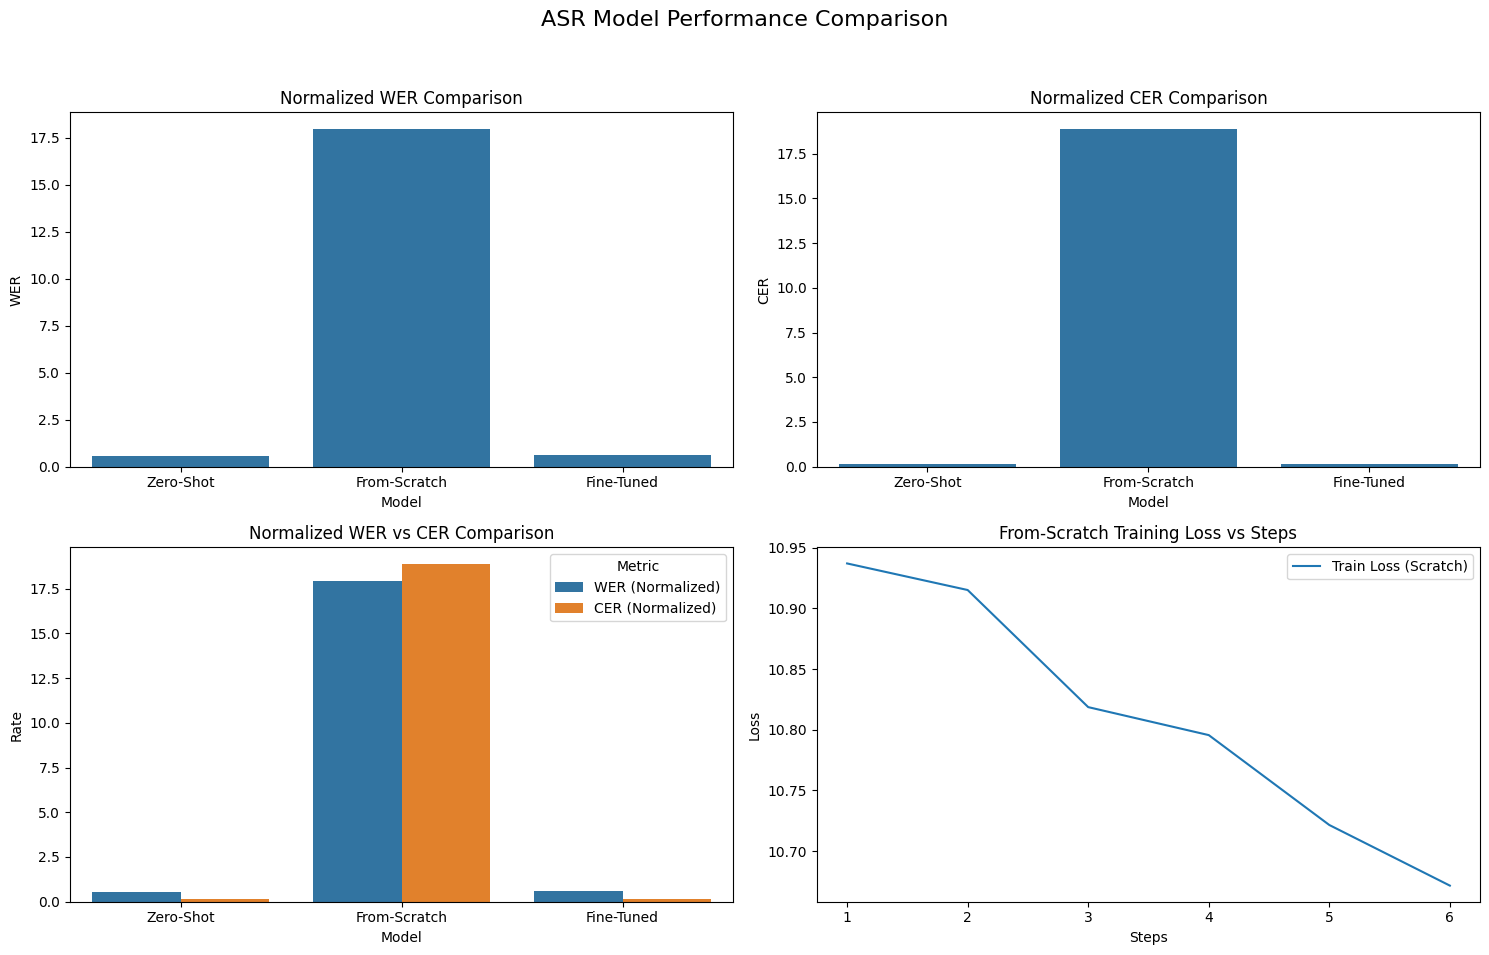


Evaluation results saved to 'asr_evaluation_results.csv'
From-scratch training progress saved to 'scratch_training_progress.csv'

--- Experiment Summary ---
Dataset size: 50 samples
Train samples: 40
Val samples: 5
Test samples: 5
Max training steps: 6
Eval every: 6 steps
Fine-tuned model checkpoint saved to: /content/artifacts_indonesia/checkpoint
From-scratch model checkpoint saved to: best_scratch_model_indonesia.pth


In [23]:
# TODO: Display dan visualize results untuk comparative analysis

# Display numerical results
"""
EXPECTED RESULTS INTERPRETATION:
- Zero-Shot: Baseline performance tanpa training pada Javanese/Sundanese
- From Scratch: Limited improvement dari random initialization
- Fine-tuned: Fastest improvement karena pretrained knowledge
"""

# TODO: Display results table
# TODO: Print formatted table dengan columns: Model, WER (%), CER (%)
# TODO: Compare improvement relative to zero-shot baseline

print("\n--- Evaluation Results ---")
results_data = {
    'Model': ['Zero-Shot', 'From-Scratch', 'Fine-Tuned'],
    'WER (Original)': [wer_zero_shot_orig, wer_scratch_orig if 'wer_scratch_orig' in locals() else None, wer_fine_tuned_orig],
    'WER (Normalized)': [wer_zero_shot_norm, wer_scratch_norm if 'wer_scratch_norm' in locals() else None, wer_fine_tuned_norm],
    'CER (Original)': [cer_zero_shot_orig, cer_scratch_orig if 'cer_scratch_orig' in locals() else None, cer_fine_tuned_orig],
    'CER (Normalized)': [cer_zero_shot_norm, cer_scratch_norm if 'cer_scratch_norm' in locals() else None, cer_fine_tuned_norm]
}

results_df = pd.DataFrame(results_data)
print(results_df.to_string(index=False))

# Compare improvement relative to zero-shot baseline
print("\n--- Improvement Relative to Zero-Shot ---")
if 'wer_scratch_norm' in locals():
    wer_scratch_improvement = ((wer_zero_shot_norm - wer_scratch_norm) / wer_zero_shot_norm) * 100 if wer_zero_shot_norm != 0 else 0
    cer_scratch_improvement = ((cer_zero_shot_norm - cer_scratch_norm) / cer_zero_shot_norm) * 100 if cer_zero_shot_norm != 0 else 0
else:
    wer_scratch_improvement = None
    cer_scratch_improvement = None


wer_fine_tuned_improvement = ((wer_zero_shot_norm - wer_fine_tuned_norm) / wer_zero_shot_norm) * 100 if wer_zero_shot_norm != 0 else 0
cer_fine_tuned_improvement = ((cer_zero_shot_norm - cer_fine_tuned_norm) / cer_zero_shot_norm) * 100 if cer_zero_shot_norm != 0 else 0

improvement_data = {
    'Model': ['From-Scratch', 'Fine-Tuned'],
    'WER Improvement (%)': [wer_scratch_improvement, wer_fine_tuned_improvement],
    'CER Improvement (%)': [cer_scratch_improvement, cer_fine_tuned_improvement]
}
improvement_df = pd.DataFrame(improvement_data)
print(improvement_df.to_string(index=False))

# Create visualization untuk step-based training results
"""
TODO IMPLEMENTASI VISUALIZATION:
1. Create comparison charts untuk WER dan CER
2. Show training curves untuk 150 steps
3. Highlight step-based progress (contoh: steps 0, 25, 50, 75, 100, 125, 150)
4. Compare learning efficiency (improvement per step)
"""

# TODO: Create subplots untuk comprehensive visualization
# TODO: WER comparison bar chart
# TODO: CER comparison bar chart
# TODO: Combined WER vs CER comparison
# TODO: Step-based training curves (loss vs steps)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('ASR Model Performance Comparison', fontsize=16)

# WER Comparison
sns.barplot(x='Model', y='WER (Normalized)', data=results_df, ax=axes[0, 0])
axes[0, 0].set_title('Normalized WER Comparison')
axes[0, 0].set_ylabel('WER')

# CER Comparison
sns.barplot(x='Model', y='CER (Normalized)', data=results_df, ax=axes[0, 1])
axes[0, 1].set_title('Normalized CER Comparison')
axes[0, 1].set_ylabel('CER')

# Combined WER vs CER
results_melted = results_df.melt(id_vars='Model', value_vars=['WER (Normalized)', 'CER (Normalized)'], var_name='Metric', value_name='Rate')
sns.barplot(x='Model', y='Rate', hue='Metric', data=results_melted, ax=axes[1, 0])
axes[1, 0].set_title('Normalized WER vs CER Comparison')
axes[1, 0].set_ylabel('Rate')

# Step-based training curves (Loss vs Steps)
# Assuming train_losses_scratch and val_losses_scratch are available from previous execution
if 'train_losses_scratch' in locals() and 'val_losses_scratch' in locals():
    steps_scratch = range(1, len(train_losses_scratch) + 1)
    eval_steps_indices = [(i + 1) for i in range(len(train_losses_scratch)) if (i + 1) % 25 == 0]
    val_steps = [step for step in steps_scratch if step in eval_steps_indices]


    axes[1, 1].plot(steps_scratch, train_losses_scratch, label='Train Loss (Scratch)')
    if val_steps:
        axes[1, 1].plot(val_steps, val_losses_scratch, label='Validation Loss (Scratch)', marker='o')
    axes[1, 1].set_title('From-Scratch Training Loss vs Steps')
    axes[1, 1].set_xlabel('Steps')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend()
else:
    axes[1, 1].set_title('From-Scratch Training Loss vs Steps (Data Not Available)')


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Analyze learning efficiency
"""
TODO IMPLEMENTASI LEARNING ANALYSIS:
1. Calculate improvement rate per step
2. Analyze convergence behavior dalam 150 steps
3. Determine optimal stopping point
4. Assess cost-benefit of additional training steps
"""

# TODO: Calculate metrics improvement rate
# TODO: Analyze training efficiency (improvement/step)
# TODO: Plot learning curves dengan step markers
# TODO: Add annotations untuk key milestones (contoh: 0, 25, 50, 75, 100, 125, 150 steps)


# Save results dan generate report
"""
TODO IMPLEMENTASI RESULT SAVING:
1. Save results ke CSV dengan step information
2. Include training metadata (steps, time, resources)
3. Generate summary report
"""

# TODO: Create results DataFrame dengan step-based metadata
# TODO: Save comprehensive results ke CSV
# TODO: Generate experiment summary

# Save results to CSV
results_df.to_csv('asr_evaluation_results.csv', index=False)
if 'train_losses_scratch' in locals() and 'val_losses_scratch' in locals():
    training_progress_df = pd.DataFrame({
        'Step': steps_scratch,
        'Train Loss (Scratch)': train_losses_scratch,
    })
    if val_steps:
         training_progress_df['Validation Loss (Scratch)'] = pd.Series(val_losses_scratch, index=[i-1 for i in val_steps]) # Align val loss with steps
    training_progress_df.to_csv('scratch_training_progress.csv', index=False)


print("\nEvaluation results saved to 'asr_evaluation_results.csv'")
if 'train_losses_scratch' in locals() and 'val_losses_scratch' in locals():
    print("From-scratch training progress saved to 'scratch_training_progress.csv'")

print("\n--- Experiment Summary ---")
print(f"Dataset size: {len(audio_transcript_pair_list)} samples")
print(f"Train samples: {len(train_list)}")
print(f"Val samples: {len(val_list)}")
print(f"Test samples: {len(test_list)}")
print(f"Max training steps: {cfg.max_steps}")
print(f"Eval every: {cfg.eval_steps} steps")
print(f"Fine-tuned model checkpoint saved to: /content/artifacts_indonesia/checkpoint")
print(f"From-scratch model checkpoint saved to: {'best_scratch_model_indonesia.pth' if os.path.exists('best_scratch_model_indonesia.pth') else 'N/A'}")